# Random Forest

In this tutorial, we cover the theoretical and practical aspects of Random Forest algorithms. We discuss the underlying principles, provide detailed code examples, and compare Random Forests with other machine learning methods.

## Objectives

- **Theoretical Background:** Understand ensemble methods, bagging, and the bias-variance trade-off behind Random Forests.
- **Exploratory Data Analysis (EDA):** Analyze and visualize data to gain insights before modeling.
- **Random Forest Model Implementation:** Evaluate model performance using accuracy, confusion matrices, ROC curves, and classification reports.
- **Hyperparameter Tuning:** Optimize key parameters to improve model performance.
- **Model Comparison:** Compare Random Forests with Decision Trees, Logistic Regression, and Gradient Boosting.
- **Advanced Topics:** Explore out-of-bag error estimation, handling imbalanced datasets, and model interpretability with tools like SHAP/LIME.
- **Concluding Remarks**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

import shap

# Set plot style
sns.set(style='whitegrid')
%matplotlib inline

## 1. Theoretical Background

### 1.1 Random Forest Fundamentals
- **Ensemble Method:** Combines multiple decision trees to reduce variance.
- **Bagging (Bootstrap Aggregating):** Uses random subsets of data to train each tree.
- **Feature Randomness:** Selects a random subset of features at each split to improve diversity among trees.
- **Bias-Variance Trade-off:** Balances the low bias of decision trees with reduced variance by averaging multiple models.

### 1.2 When and Why to Use Random Forests
- **High-dimensional Data:** Effective when handling datasets with many features.
- **Non-linear Relationships:** Capable of modeling complex interactions between features.
- **Feature Importance:** Automatically provides a ranking of feature relevance.
- **Robustness:** Tolerant of outliers and noise in the data.

### 1.3 Limitations
- **Computational Cost:** More resource-intensive than simpler models, especially with many trees.
- **Interpretability:** The ensemble nature makes it harder to interpret compared to a single decision tree.
- **Memory Usage:** Storing many trees can require significant memory resources.
- **Potential Overfitting:** Can overfit noisy datasets if not properly tuned.

## 2. Exploratory Data Analysis (EDA)

We will use the classic Iris dataset to illustrate the implementation. This section covers loading the data and performing exploratory data analysis (EDA).

In [4]:
# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target

# Map numeric target to species names
species_mapping = {i: name for i, name in enumerate(iris.target_names)}
df['species'] = df['species'].map(species_mapping)

print('Dataset shape:', df.shape)
display(df.head())

Dataset shape: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


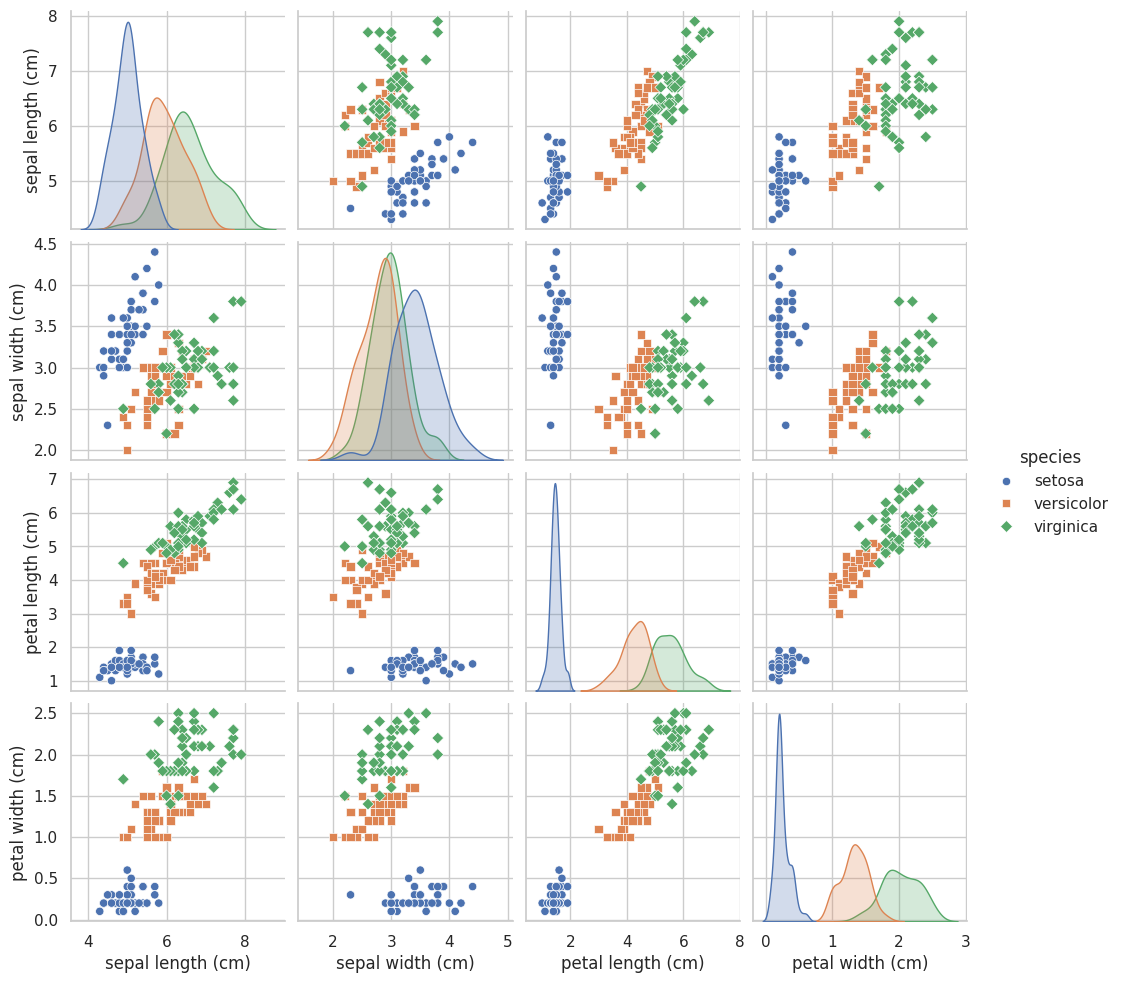

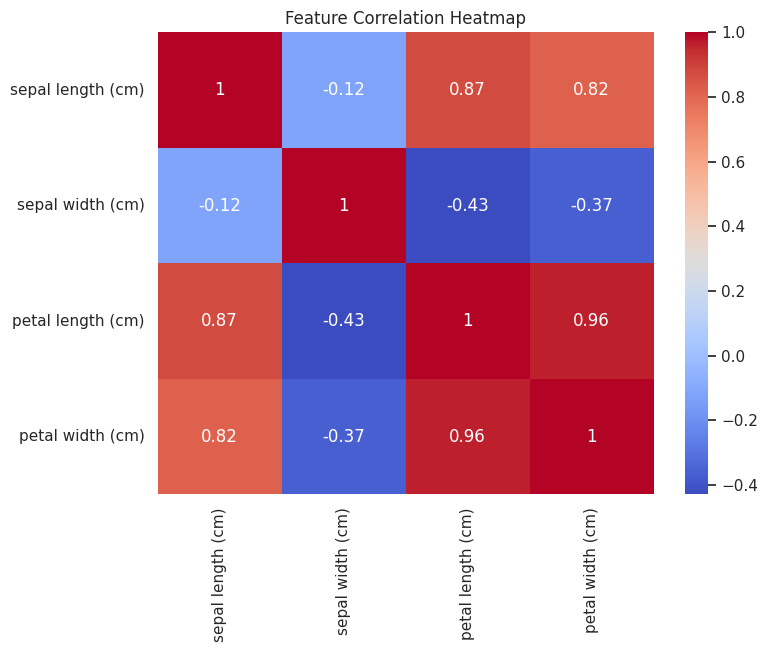

In [5]:
sns.pairplot(df, hue='species', markers=['o', 's', 'D'])
plt.show()

# Correlation heatmap for the features
plt.figure(figsize=(8,6))
corr = df.drop('species', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## 3. Random Forest Model Implementation

### 3.1 Data Preparation
We split the dataset into training and testing sets. Stratified sampling ensures each class is proportionally represented.

In [6]:
# Split the data
X = df.drop('species', axis=1)
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (105, 4)
Testing set shape: (45, 4)


### 3.2 Building and Training the Random Forest Model

We instantiate a Random Forest classifier and enable out-of-bag (OOB) score estimation for an additional evaluation metric.

#### The Out-of-Bag (OOB) Score:

- Random Forests employ a technique called bootstrap aggregating, or "bagging," where each decision tree in the ensemble is trained on a random subset of the original dataset, selected with replacement. Consequently, for each tree, some samples are not included in its training subset; these are referred to as out-of-bag samples.

- The OOB score is determined by using these out-of-bag samples to evaluate the model's performance. Specifically, each tree predicts the labels for its respective OOB samples, and the aggregated results across all trees provide an estimate of the model's generalization accuracy. This method offers an internal cross-validation mechanism, allowing for performance assessment without the need for a separate validation set.

In [9]:
# Initialization
rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=3, 
                             random_state=42, 
                             oob_score=True)
rf.fit(X_train, y_train)

# Display the Out-of-Bag score
if hasattr(rf, 'oob_score_'):
    print('Out-of-Bag Score:', rf.oob_score_)

Out-of-Bag Score: 0.9523809523809523


### 3.3 Model Evaluation

We evaluate the model using several metrics including accuracy, a confusion matrix, and a classification report.

Accuracy: 0.91


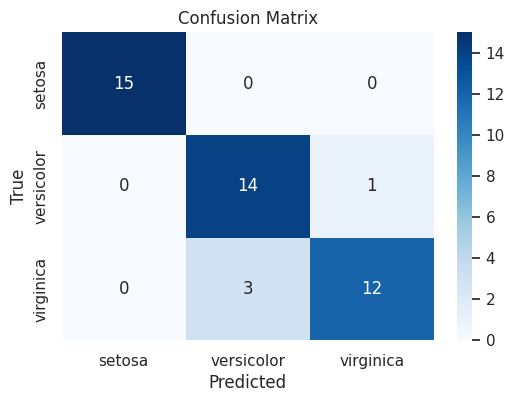

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



In [10]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=list(iris.target_names))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

### 3.4 Visualizing a Single Decision Tree

Although Random Forests are ensembles, visualizing an individual tree can provide insights into the decision process.

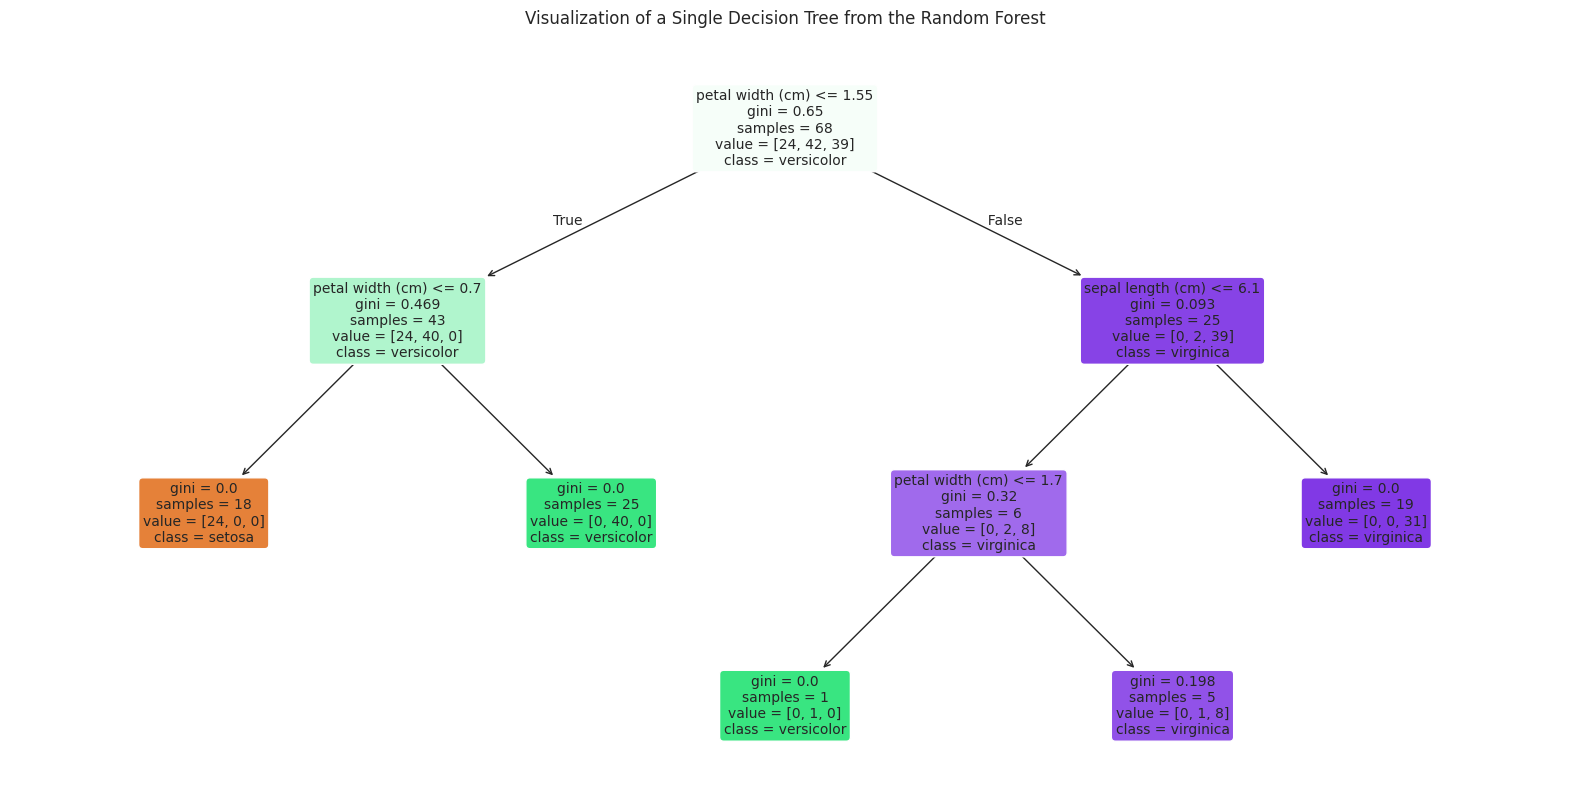

In [11]:
# Visualize one of the trees from the forest
plt.figure(figsize=(20,10))
estimator = rf.estimators_[0]
plot_tree(estimator, 
          feature_names=X.columns, 
          class_names=iris.target_names, 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title('Visualization of a Single Decision Tree from the Random Forest')
plt.show()

### 3.5 Feature Importance

Feature importance helps us understand which features contribute most to the model's predictions.

/tmp/ipykernel_2957/1490922699.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=importances, palette='viridis')


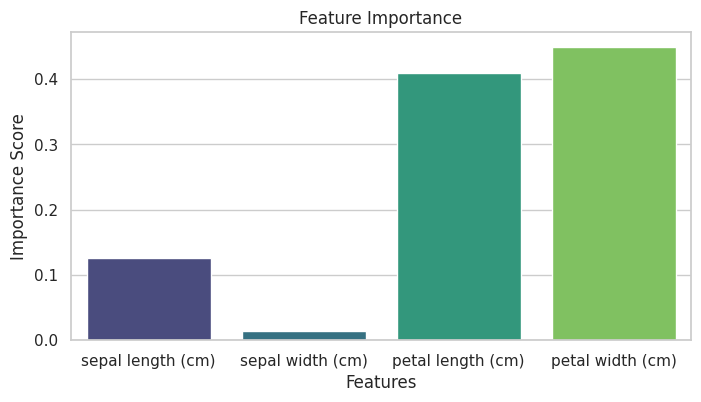

In [13]:
# Plot feature importances
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,4))
sns.barplot(x=feature_names, y=importances, palette='viridis')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

## 4. Hyperparameter Tuning:

Optimizing the model parameters can improve performance. Here, we use GridSearchCV to search over a range of hyperparameters.

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print('Best CV Score:', grid_search.best_score_)

# Re-train the model using the best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print(f"Accuracy with Best Parameters: {accuracy_score(y_test, y_pred_best):.2f}")

Best Parameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Score: 0.9619047619047618
Accuracy with Best Parameters: 0.91


## 5. Model Comparisons

### 5.1 Decision Tree vs. Random Forest

We compare a single Decision Tree with the ensemble Random Forest to understand the benefits of ensembling.

In [15]:
# Train a single Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_pred):.2f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))

# Train a Logistic Regression model for further comparison
lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.2f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))

Decision Tree Accuracy: 0.93
Decision Tree Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.80      0.89        15
   virginica       0.83      1.00      0.91        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45

Logistic Regression Accuracy: 0.93
Logistic Regression Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



### 5.2 Advanced Model Comparison: Gradient Boosting

For a broader perspective, we compare Random Forests with another ensemble method, Gradient Boosting.

In [16]:
# Train a Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, gb_pred):.2f}")
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_pred))

Gradient Boosting Accuracy: 0.93
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



## 6. Advanced Topics and Interpretability

### 6.1 Out-of-Bag (OOB) Error

Random Forests can estimate the generalization error using the out-of-bag samples. This is useful when cross-validation is computationally expensive.

In [17]:
# The OOB score was already computed during training (see earlier cell)
print('OOB Score:', rf.oob_score_)

OOB Score: 0.9523809523809523


### 6.2 Model Interpretability

While Random Forests are inherently less interpretable than single decision trees, tools like SHAP or LIME can help explain individual predictions.

Example (uncomment the following code if SHAP is installed):

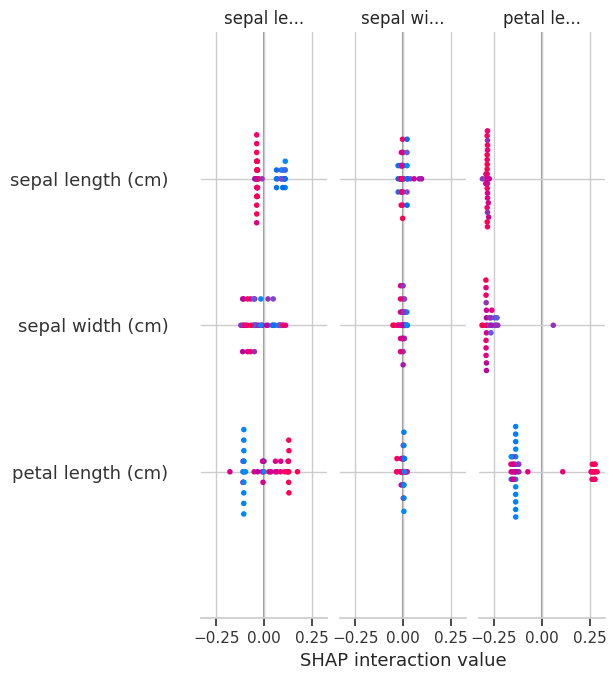

In [18]:
# Example for SHAP (requires installation of shap library)
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

#### 6.2.1 How to Interpret SHAP Values
##### Magnitude of SHAP Value

- Higher magnitude = stronger impact on the prediction.
- Near zero = little to no impact.
- Sign of SHAP Value

- Positive SHAP value = feature is pushing the prediction higher (toward a positive class in classification, or increasing the output in regression).
- Negative SHAP value = feature is pushing the prediction lower.

##### Example
Let’s say you’re predicting if a loan will be approved (1) or not (0).

Model Prediction: 0.85 (high chance of approval)
Baseline Prediction (average without any feature): 0.50
SHAP values for one specific person:

Income SHAP Value = +0.20 (higher income increases approval likelihood)
Credit History SHAP Value = +0.15 (good credit helps)
Debt SHAP Value = -0.05 (high debt reduces approval chance)
Final prediction = 0.50 (baseline) + 0.20 (income) + 0.15 (credit history) - 0.05 (debt) = 0.85

This breakdown shows exactly how much each feature pushed the prediction up or down.

## 7. Concluding Remarks

### Strengths
- **High Predictive Performance:** Excellent accuracy on complex and high-dimensional datasets.
- **Robustness:** Handles noisy data and outliers well due to ensemble averaging.
- **Feature Insights:** Provides a ranking of feature importances that can guide further analysis.
- **Flexibility:** Can be used for both classification and regression tasks.

### Weaknesses
- **Computational Cost:** Training and predicting can be slower compared to simpler models.
- **Interpretability:** The ensemble nature makes it less transparent than a single decision tree.
- **Memory Intensive:** A large number of trees can consume significant memory.
- **Potential Overfitting:** If not tuned properly, there is a risk of overfitting, especially with noisy data.